In [1]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
# %jsroot on
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath
import portROOT2pd

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")

fileList = filepath.getfilelist(["SiDet1CMBScan"],"recoROOT",6)[0]
additional_dict = {'VoverN'    :filepath.datatag["SiDet1CMBScan"]["VoverN"],
                   'VppN'      :filepath.datatag["SiDet1CMBScan"]["VppN"],
                   'tempSetup' :filepath.datatag["SiDet1CMBScan"]["tempSetup"],
                   'tempSensor':filepath.datatag["SiDet1CMBScan"]["tempSensor"]}

nSmooth = 1 

plotdict = {'*':[["temperatureCMB[0][0]","temperatureCMB[0][16]"], 
                 ["temperatureFEB[0]"],
                 ["busSiPMBias[0][0:4]"], 
                 ["busSiPMBias[0][4:8]"]]}

Welcome to JupyROOT 6.28/10


Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001434_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001433_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001435_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001436_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001437_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001438_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001439_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001440_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001441_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001442_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001452_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001443_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.00

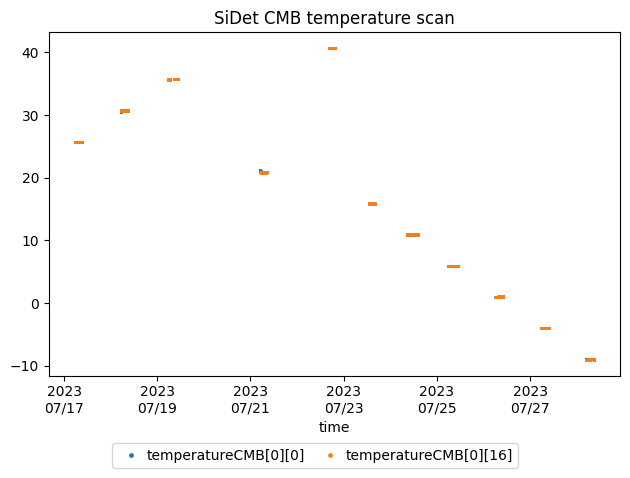

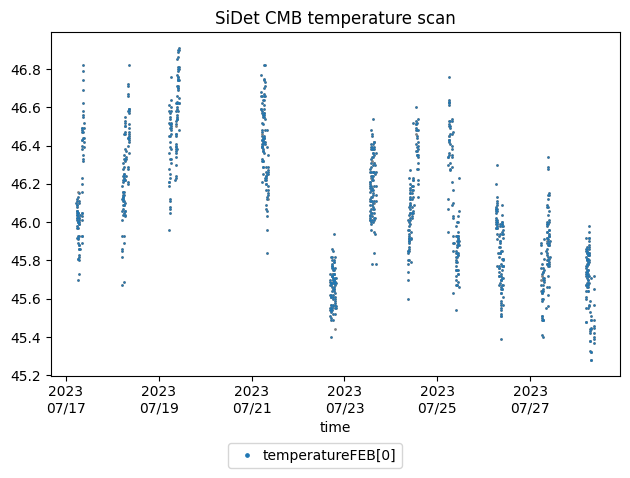

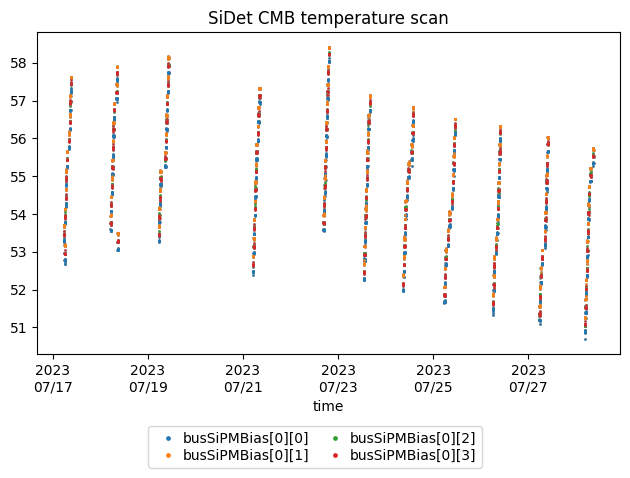

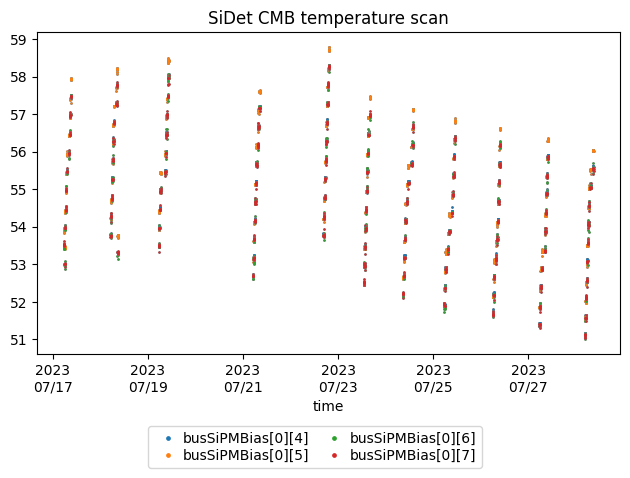

In [2]:
tfig = utils.plot_dqm(fileList, plotdict, '== 0x0', False, nSmooth, True, "SiDet CMB temperature scan;time;") 
#tfig = utils.plot_dqm(fileList, plotdict, '& 0xfffffffffffffe == 0x0', False, nSmooth, True, "SiDet gain calibration scan;time;") 

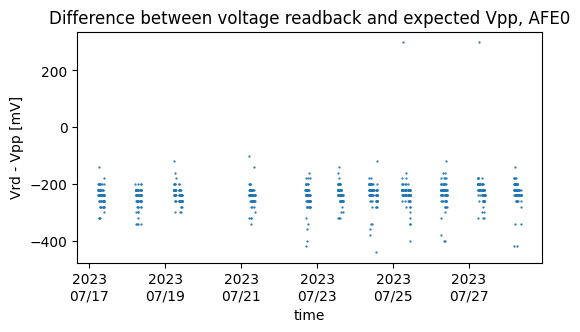

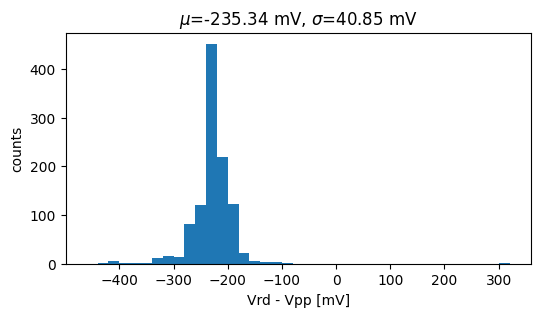

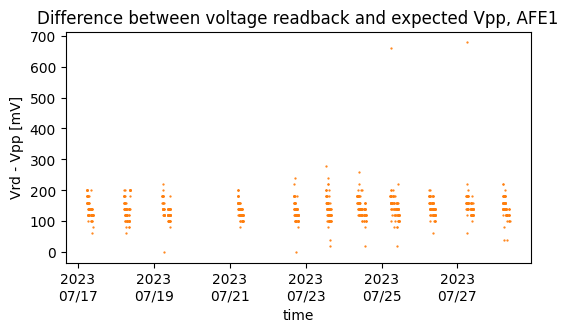

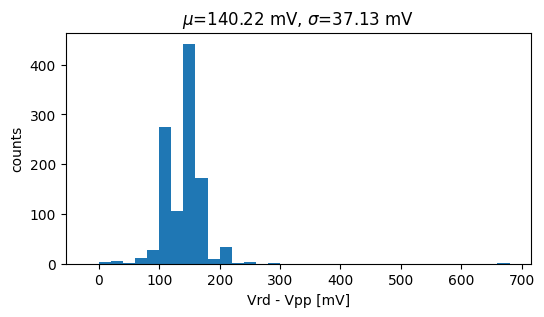

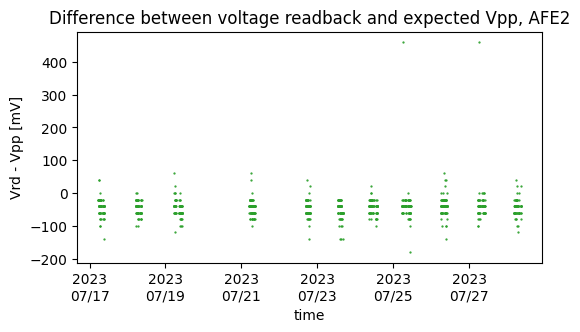

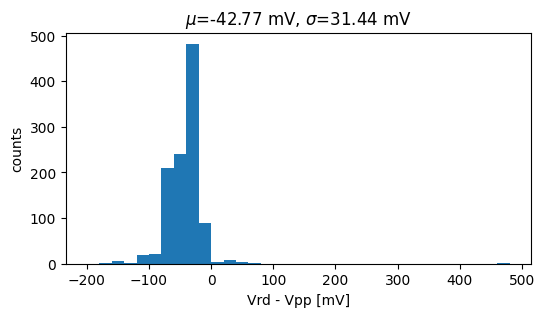

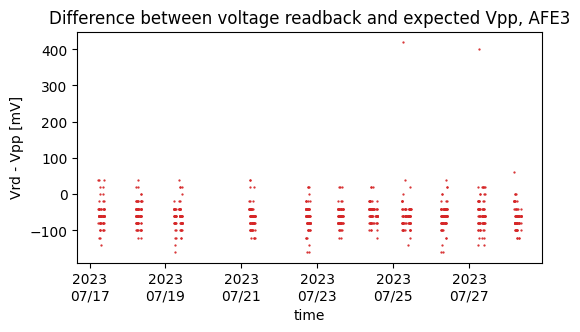

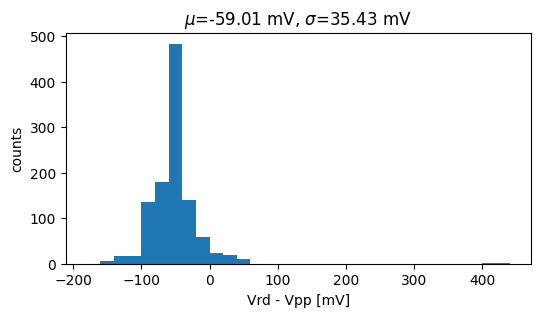

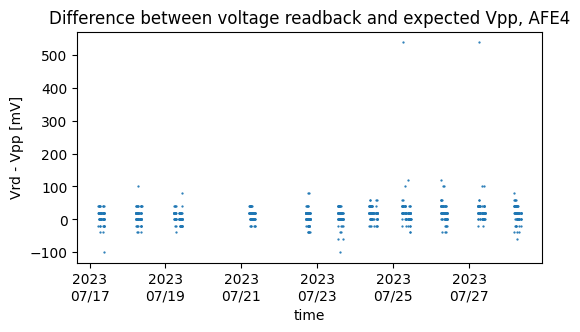

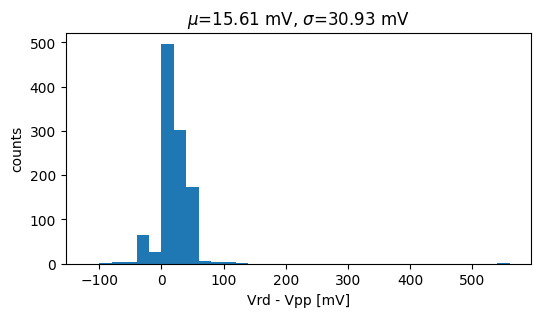

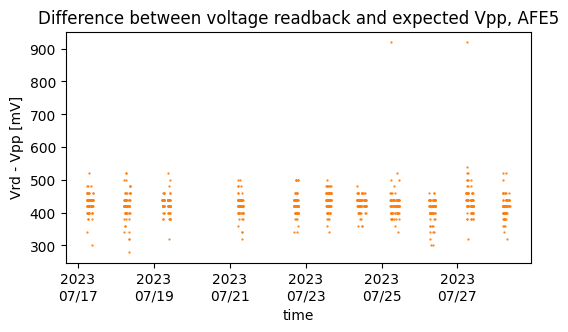

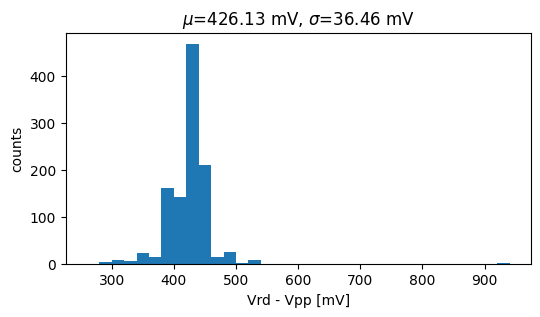

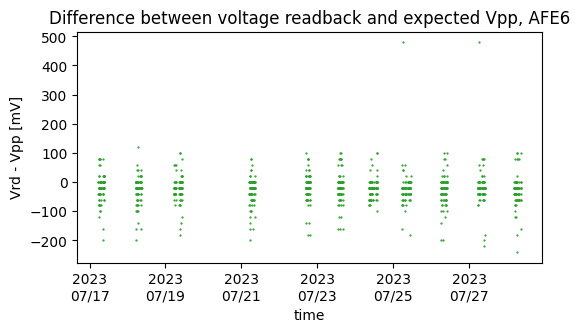

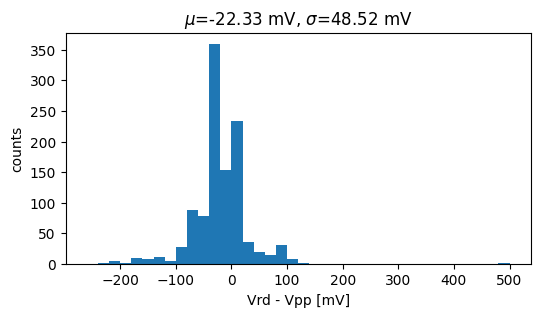

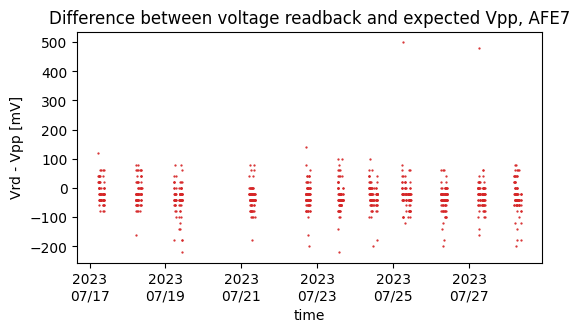

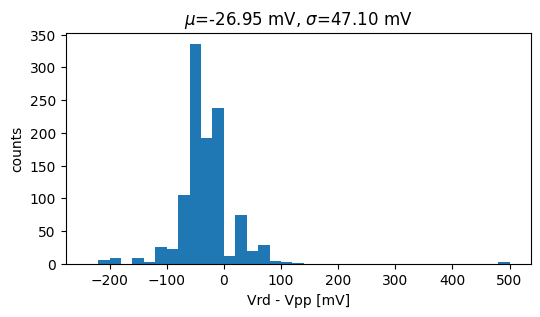

In [3]:
# assemble norminal Vpp array
VppN_perspill = []
for i, filename in enumerate(fileList):
    fFile = ROOT.TFile(filename, "READ")
    spilltree = fFile.Get("spills")
    nSpill = spilltree.GetEntries()
    VppN_perspill += [filepath.datatag["SiDet1CMBScan"]["VppN"][i]]*nSpill
    fFile.Close()
VppN_perspill = np.array(VppN_perspill)
VppN_list = [(VppN_perspill) for i in range(8)]

for iAFE in range(8):
    tline = tfig[2+int(iAFE/4)].gca().get_lines()[(iAFE%4)*2]
    xdata = tline.get_xdata()
    xdata = np.array([xdata[i].timestamp() for i in range(xdata.size)])
    ydata = tline.get_ydata()
    # print(ydata)
    plot_data = 1000.*(ydata-VppN_list[iAFE])
    
    plt.figure(figsize = (6,3))
    utils.plot_ts(xdata, plot_data, '.', markersize=1.2,  
                       rasterized=True, color=constants.colors[iAFE%4%10])
    ax = plt.gca()
    ax.set_title("Difference between voltage readback and expected Vpp, AFE%i"%iAFE)
    ax.set_xlabel("time")
    ax.set_ylabel("Vrd - Vpp [mV]")
    plt.show()

    plt.figure(figsize = (6,3))
    rangemin = np.min(plot_data)-20
    rangemax = np.max(plot_data)+20
    step = 20
    nbins = int((rangemax-rangemin)/step)
    plt.hist(plot_data, [float(rangemin)+step*float(i) for i in range(nbins+1)])
    plt.title(r'$\mu$'+"=%.2f mV"%(np.mean(plot_data))+r', $\sigma$'+"=%.2f mV"%(np.std(plot_data)))
    plt.xlabel("Vrd - Vpp [mV]")
    plt.ylabel("counts")
    plt.show()


In [4]:
import pandas as pd
import pickle
from scipy import stats

df = portROOT2pd.PortToDF(fileList, additional_dict)
pklname = os.path.join(analysis_dir,"tempScanSiDetRun1.pkl")

with open(pklname, 'wb') as f:
    pickle.dump(df, f)

In [1]:
from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
pklname = os.path.join(analysis_dir,"tempScanSiDetRun1.pkl")

with open(pklname, 'rb') as f:
    df = pickle.load(f)

# remove runs with Vover < 2.5V 
df = df.query("VoverN > 2.0").reset_index() 

display(df)
#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    print(df)


index   run  subrun  FEB  ch  pedestal    calibRaw    calibAdj  \
0       128  1435       0    0   0 -11.18370  307.683014  352.442993   
1       129  1435       0    0   1  17.38870  318.423004  362.578003   
2       130  1435       0    0   2   1.86174  324.580994  368.518005   
3       131  1435       0    0   3  -1.29567  315.535004  359.811005   
4       132  1435       0    0   4 -11.68880  312.257996  356.007996   
...     ...   ...     ...  ...  ..       ...         ...         ...   
5627   7035  1595       0    0  59  -7.15974  769.568970  571.517029   
5628   7036  1595       0    0  60  -8.64262  763.041016  565.848999   
5629   7037  1595       0    0  61  -4.63297  791.271973  593.619995   
5630   7038  1595       0    0  62   2.16293  771.695007  574.330017   
5631   7039  1595       0    0  63   8.47691  752.640991  554.851990   

       FEBtemp    CMBtemp      biasV        PEs  PEsCorrected  VoverN  VppN  \
0     45.88222  25.500000  53.775555  31.867464     33.956245     2.5  54.0   
1     45.88222  25.500000  53.775555  32.256924     34.435741     2.5  54.0   
2     45.88222  25.500000  53.775555  47.698593     50.959114     2.5  54.0   
3     45.88222  25.500000  53.775555  41.438473     44.227039     2.5  54.0   
4     45.88222  25.493055  53.775555  27.565544     29.456230     2.5  54.0   
...        ...        ...        ...        ...           ...     ...   ...   
5627    45.492  -8.975000  55.533997  55.825016     40.766563     6.0  55.6   
5628    45.492  -9.037500  55.533997  37.644634     27.435452     6.0  55.6   
5629    45.492  -9.037500  55.533997  41.168488     29.982683     6.0  55.6   
5630    45.492  -9.037500  55.533997  43.015720     31.343134     6.0  55.6   
5631    45.492  -9.037500  55.533997  45.963543     33.510174     6.0  55.6   

      tempSetup  tempSensor  
0          25.0        25.0  
1          25.0        25.0  
2          25.0        25.0  
3          25.0        25.0  
4          25.0        25.0  
...         ...         ...  
5627      -10.0        -9.4  
5628      -10.0        -9.4  
5629      -10.0        -9.4  
5630      -10.0        -9.4  
5631      -10.0        -9.4  

[5632 rows x 17 columns]

level_0  index   run  subrun  FEB  ch  pedestal  calibRaw    calibAdj  \
0      1574   2086  1499       0    0  38  -9.73594       0.0    0.000000   
1      1766   2278  1502       0    0  38  -9.70710       0.0    0.000000   
2      1830   2342  1503       0    0  38  -9.69925       0.0    0.000000   
3      1894   2406  1504       0    0  38  -9.68898       0.0    0.000000   
4      1938   2450  1505       0    0  18   6.93118       0.0    0.000000   
5      1958   2470  1505       0    0  38  -9.74493       0.0    0.000000   
6      2022   2534  1506       0    0  38  -9.75766       0.0  365.083008   
7      2618   3386  1518       0    0  58   1.09738       0.0    0.000000   
8      3066   3834  1525       0    0  58   1.15064       0.0    0.000000   
9      3450   4346  1540       0    0  58   1.01758       0.0    0.000000   
10     3514   4410  1541       0    0  58   1.01176       0.0    0.000000   
11     3578   4474  1542       0    0  58   1.09621       0.0    0.000000   
12     3642   4666  1549       0    0  58   1.15967       0.0    0.000000   
13     3706   4730  1550       0    0  58   1.04338       0.0    0.000000   
14     3770   4794  1551       0    0  58   1.12717       0.0    0.000000   
15     3834   4858  1552       0    0  58   1.08745       0.0    0.000000   
16     3898   4922  1553       0    0  58   1.06871       0.0    0.000000   
17     3962   4986  1554       0    0  58   1.15879       0.0    0.000000   
18     4026   5050  1555       0    0  58   1.07970       0.0    0.000000   
19     4090   5114  1556       0    0  58   1.11884       0.0    0.000000   
20     4134   5286  1562       0    0  38  -9.81924       0.0    0.000000   
21     4154   5306  1562       0    0  58   1.12848       0.0    0.000000   
22     4198   5350  1563       0    0  38  -9.90566       0.0    0.000000   
23     4218   5370  1563       0    0  58   1.17038       0.0    0.000000   
24     4410   5562  1566       0    0  58   1.19818       0.0    0.000000   
25     4646   5926  1575       0    0  38  -9.87527       0.0    0.000000   
26     4710   5990  1576       0    0  38  -9.86238       0.0    0.000000   
27     4774   6054  1577       0    0  38  -9.86922       0.0    0.000000   
28     4838   6118  1578       0    0  38  -9.81480       0.0    0.000000   
29     4902   6182  1579       0    0  38  -9.76968       0.0    0.000000   
30     4966   6246  1580       0    0  38  -9.79461       0.0    0.000000   
31     5030   6310  1581       0    0  38  -9.85116       0.0    0.000000   
32     5094   6374  1582       0    0  38  -9.87922       0.0    0.000000   
33     5158   6566  1588       0    0  38  -9.77480       0.0    0.000000   
34     5222   6630  1589       0    0  38  -9.86458       0.0    0.000000   
35     5286   6694  1590       0    0  38  -9.92751       0.0    0.000000   
36     5350   6758  1591       0    0  38  -9.89536       0.0    0.000000   
37     5414   6822  1592       0    0  38  -9.87288       0.0    0.000000   
38     5478   6886  1593       0    0  38  -9.79727       0.0    0.000000   
39     5542   6950  1594       0    0  38  -9.88440       0.0    0.000000   
40     5606   7014  1595       0    0  38  -9.84970       0.0    0.000000   

      FEBtemp    CMBtemp      biasV  PEs  PEsCorrected  VoverN  VppN  \
0   45.648003  40.375000  54.809998  0.0           0.0     2.5  54.8   
1   45.653004  40.356251  56.303997  0.0           0.0     4.0  56.3   
2      45.699  40.356251  56.822002  0.0           0.0     4.5  56.8   
3   45.739002  40.362499  57.288002  0.0           0.0     5.0  57.3   
4      45.661  40.318748  57.747997  0.0           0.0     5.5  57.8   
5      45.661  40.349998  57.793999  0.0           0.0     5.5  57.8   
6   45.617775  40.347221  58.304443  0.0           0.0     6.0  58.3   
7   46.162224  15.805555  53.451111  0.0           0.0     2.5  53.5   
8      46.135  15.806250  56.986000  0.0           0.0     6.0  57.0   
9   46.483334  10.868055  55.666668  0.0         

[18 38 58]


Text(0, 0.5, 'counts')

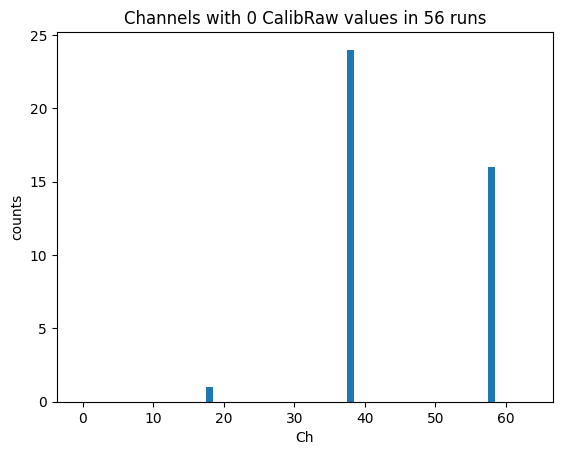

In [2]:
df1 = df.query("calibRaw == 0.0").reset_index()
display(df1)

badChannels = df1['ch'].unique()
badChannels = np.sort(badChannels)
print(badChannels)

plt.figure()
plt.hist(df1['ch'], [i-0.5 for i in range(64+1)])
plt.title("Channels with 0 CalibRaw values in 56 runs")
plt.xlabel("Ch")
plt.ylabel("counts") 

Bad channel: 38 at set temp -10 C
Bad channel: 38 at set temp -5 C
Too few Vbias: chan 38 at set temp 0 C
Too few Vbias: chan 38 at set temp 40 C
Too few Vbias: chan 58 at set temp 0 C
Bad channel: 58 at set temp 5 C
Too few Vbias: chan 58 at set temp 10 C
Too few Vbias: chan 58 at set temp 15 C


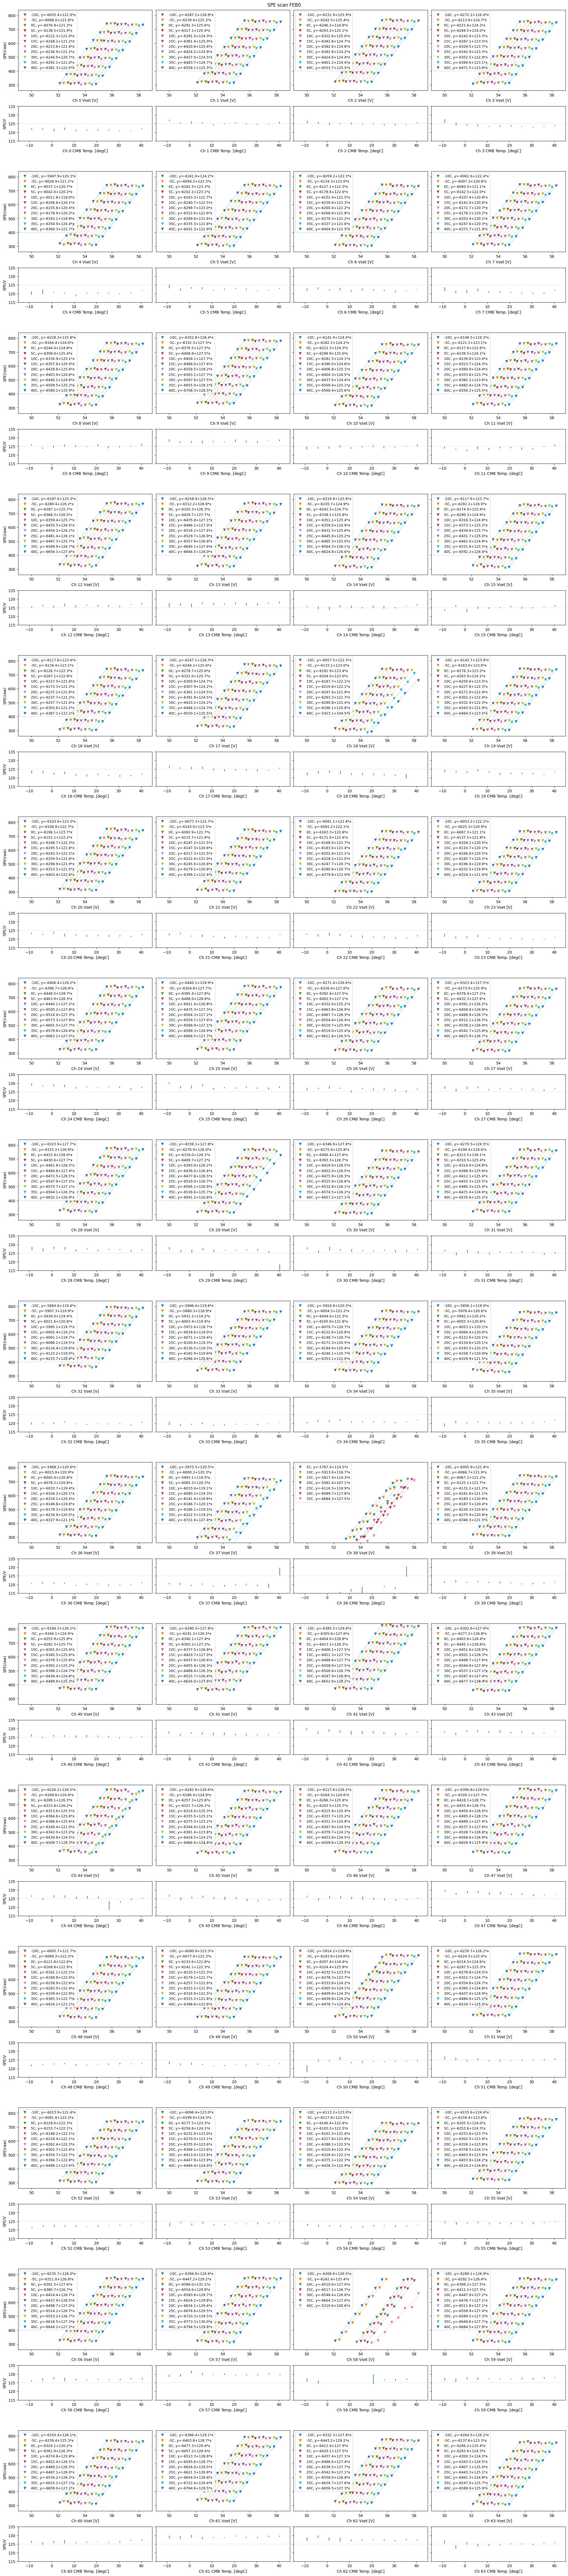

In [3]:
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

bad_channels = [18, 29, 37, 38, 44, 58]

def func_lin(x, k, b):
    return k*x+b
    
def plotter(FEBs, tempSetups, title = '', nr = 16, nc = 4):
    global bad_channels
    df_SPE = pd.DataFrame(columns=['chan', 'temp_setup', 'tempCMB_mean', 'tempCMB_err',
                                   'SPEperV', 'SPEperV_err', 'intercept', 'intercept_err',
                                   'Vbd', 'Vbd_err', 'spe_3V_over', 
                                   'spe_54V_fix', 'spe_55V_fix'])
    maintitle = title
    for FEB in FEBs:
        fig = plt.figure(layout = 'constrained', figsize = (5*nc+0.5, 5.8*nr+0.5))
        plt.suptitle(maintitle+" FEB%i"%FEB)
        subfigs = fig.subfigures(nr, 1, hspace=0.1)
        for iRow, tSubFig in enumerate(subfigs):
            axs = tSubFig.subplots(2, nc, sharey='row',
                                   gridspec_kw={'width_ratios':[5 for i in range(nc)],
                                                'height_ratios':[3.5,1.5],
                                                'wspace':0, 'hspace':0})
            ytitles = ['SPE(raw)', 'SPE/V']
            xtitles = ['Vset [V]', 'CMB Temp. [degC]']
            for ii in range(2):
                axs[ii, 0].set_ylabel(ytitles[ii])
            for ii in range(nc):
                for jj in range(2):
                    axs[jj, ii].set_xlabel('Ch %i'%(iRow*nc+ii)+' '+xtitles[jj])

            for inHDMI_chan in range(nc):
                chan = iRow*nc+inHDMI_chan
                #if chan in bad_channels:
                    #print("Skip channel %i"%chan)
                    #continue
                SPEperV_list = []
                SPEperVerr_list = []
                meanTemp_list = []
                stdTemp_list = []

                emptyFlag = True
                for tTempSetup in tempSetups:
                    df_ = df.query("FEB==%i & ch==%i & tempSetup==%i"%(FEB, chan, tTempSetup)).reset_index()
                    xx = df_['VppN'].astype(float)
                    yy = df_['calibRaw'].astype(float)
                    meanTemp = np.mean(df_['CMBtemp'].astype(float))
                    stdTemp = np.std(df_['CMBtemp'].astype(float))
                    mask = (yy>0)
                    xx=xx[mask]
                    yy=yy[mask]
                    if yy.size==0:
                        print("Bad channel: %d at set temp %.0f C"%(chan, tTempSetup))
                        continue

                    if len(xx)>3 and np.max(xx)-np.min(xx)>3:
                        emptyFlag = False
                        popt, pcov = curve_fit(func_lin, xx.astype(float), yy.astype(float))
                        slope = popt[0]
                        intercept = popt[1]
                        std_err = np.sqrt(pcov[0,0])
                        intercept_stderr = np.sqrt(pcov[1,1])
                        meanTemp_list.append(meanTemp)
                        stdTemp_list.append(stdTemp)
                        SPEperV_list.append(slope)
                        SPEperVerr_list.append(std_err)

                        tscatter = axs[0, inHDMI_chan].plot(xx, yy, 'v', label='%.0fC, y=%.1f+%.1f*x'%(tTempSetup, intercept, slope))
                        axs[0, inHDMI_chan].plot(xx, slope * xx + intercept, ':', color = tscatter[0].get_color(), linewidth=0.7)
                        axs[0, inHDMI_chan].set_xlim(49.,59.)
                        axs[0, inHDMI_chan].set_ylim(260.,840.)
                        
                        new_row = {'chan':chan, 
                                   'temp_setup':tTempSetup, 
                                   'tempCMB_mean':meanTemp, 
                                   'tempCMB_err':stdTemp,
                                   'SPEperV':slope, 
                                   'SPEperV_err':std_err, 
                                   'intercept':intercept, 
                                   'intercept_err':intercept_stderr,
                                   'Vbd':-intercept/slope, 
                                   'Vbd_err':(-intercept/slope)*np.sqrt(std_err*std_err/slope/slope+intercept_stderr*intercept_stderr/intercept/intercept),
                                   'spe_3V_over':slope*3, 
                                   'spe_54V_fix':slope*54+intercept, 
                                   'spe_55V_fix':slope*55+intercept}
                        df_SPE.loc[len(df_SPE)] = new_row
                    else:
                        print("Too few Vbias: chan %d at set temp %.0f C"%(chan, tTempSetup))
                if not emptyFlag:
                    axs[0, inHDMI_chan].legend(fontsize=9)

                SPEperV_list = np.array(SPEperV_list)
                SPEperVerr_list = np.array(SPEperVerr_list)
                meanTemp_list = np.array(meanTemp_list)
                stdTemp_list = np.array(stdTemp_list)

                axs[1, inHDMI_chan].errorbar(meanTemp_list, SPEperV_list, xerr=stdTemp_list, yerr=SPEperVerr_list,
                                             linestyle='none')
                axs[1, inHDMI_chan].axhline(y = 125, color = '#929591', linestyle = '--', linewidth=0.3) 
                axs[1, inHDMI_chan].set_xlim(-15.,45.)
                axs[1, inHDMI_chan].set_ylim(115.,135.)
    
    return df_SPE

df_SPE = plotter(FEBs, tempSetups, 'SPE scan')

In [4]:
display(df_SPE)

chan  temp_setup  tempCMB_mean  tempCMB_err     SPEperV  SPEperV_err  \
0       0       -10.0     -8.930469     0.025472  121.859519     0.529466   
1       0        -5.0     -3.938281     0.004879  121.824612     0.432950   
2       0         0.0      1.002344     0.016517  121.348690     0.714786   
3       0         5.0      5.860938     0.033621  121.887501     0.728063   
4       0        10.0     10.840246     0.028674  120.958163     0.328815   
..    ...         ...           ...          ...         ...          ...   
691    63        20.0     20.635156     0.038137  125.018853     0.232623   
692    63        25.0     25.477322     0.019480  125.061268     0.264258   
693    63        30.0     30.478472     0.016167  124.769212     0.333720   
694    63        35.0     35.455729     0.016690  125.695479     0.232514   
695    63        40.0     40.358334     0.009433  125.859876     0.299475   

       intercept  intercept_err        Vbd   Vbd_err  spe_3V_over  \
0   -6035.399599      28.518196  49.527519  0.317923   365.578557   
1   -6068.024748      23.449495  49.809514  0.261507   365.473836   
2   -6076.874037      38.928689  50.077789  0.435802   364.046069   
3   -6138.475574      39.797381  50.361813  0.443963   365.662504   
4   -6122.301701      18.072320  50.615035  0.203113   362.874490   
..           ...            ...        ...       ...          ...   
691 -6407.130168      12.901717  51.249312  0.140511   375.056560   
692 -6443.335041      14.735498  51.521428  0.160421   375.183803   
693 -6461.345719      18.708887  51.786379  0.204133   374.307637   
694 -6546.989678      13.081635  52.086119  0.141826   377.086437   
695 -6589.018842      16.938778  52.352021  0.183385   377.579627   

     spe_54V_fix  spe_55V_fix  
0     545.014424   666.873943  
1     510.504297   632.328909  
2     475.955208   597.303898  
3     443.449497   565.336998  
4     409.439118   530.397281  
..           ...          ...  
691   343.887912   468.906765  
692   309.973409   435.034677  
693   276.191746   400.960959  
694   240.566181   366.261660  
695   207.414445   333.274321  

[696 rows x 13 columns]

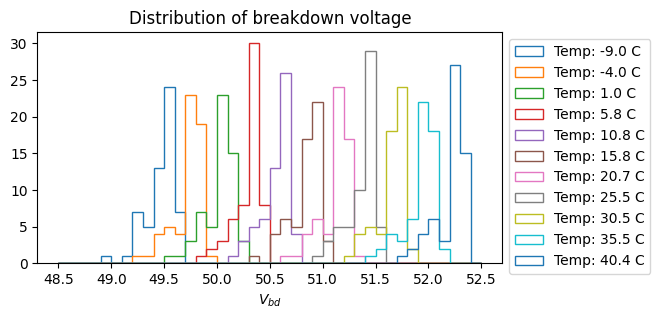

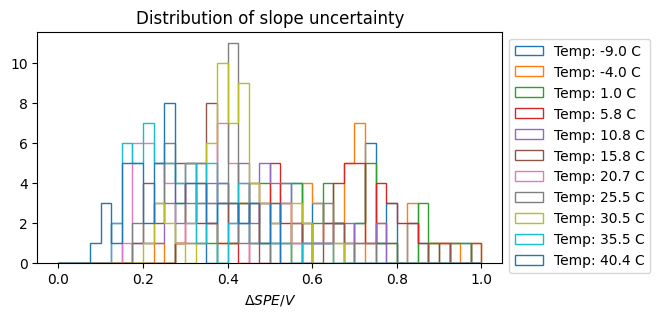

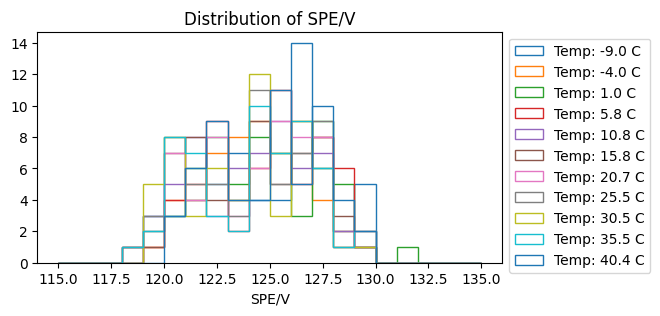

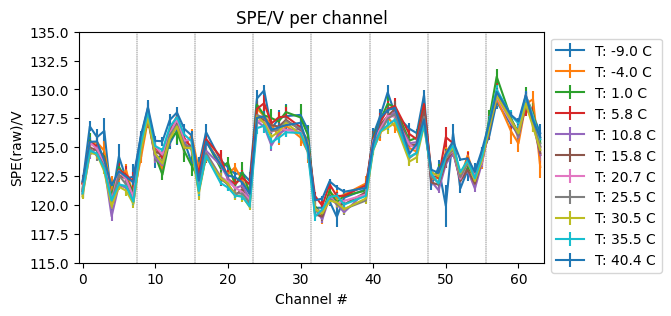

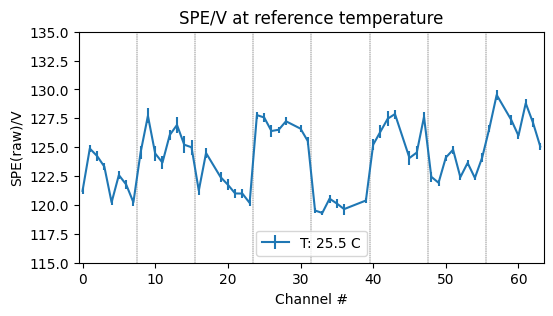

In [5]:
df_SPE_clean = df_SPE[~df_SPE['chan'].isin(bad_channels)]

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['Vbd'], bins=40, range=(48.5, 52.5), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of breakdown voltage')
plt.xlabel('$V_{bd}$')
plt.show()
    
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['SPEperV_err'], bins=40, range=(0, 1), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']));
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of slope uncertainty')
plt.xlabel('$\Delta SPE/V$')
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['SPEperV'], bins=20, range=(115, 135), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']));
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of SPE/V')
plt.xlabel('SPE/V')
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.errorbar(df_['chan'], df_['SPEperV'], yerr = df_['SPEperV_err'],
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE/V per channel")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw)/V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(115, 135)
plt.show()

plt.figure(figsize = (6,3))

df_ = df_SPE_clean.query('temp_setup == %f'%25)
plt.errorbar(df_['chan'], df_['SPEperV'], yerr = df_['SPEperV_err'],
             label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE/V at reference temperature")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw)/V")
plt.legend()
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(115, 135)
plt.show()

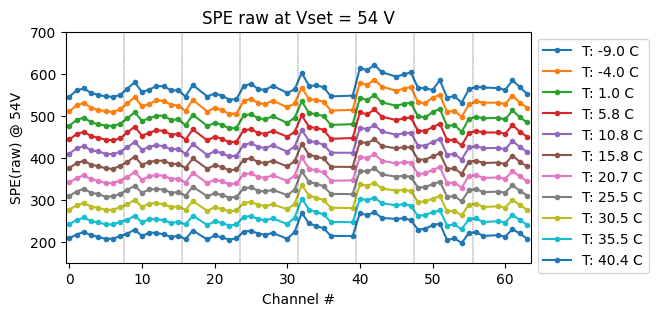

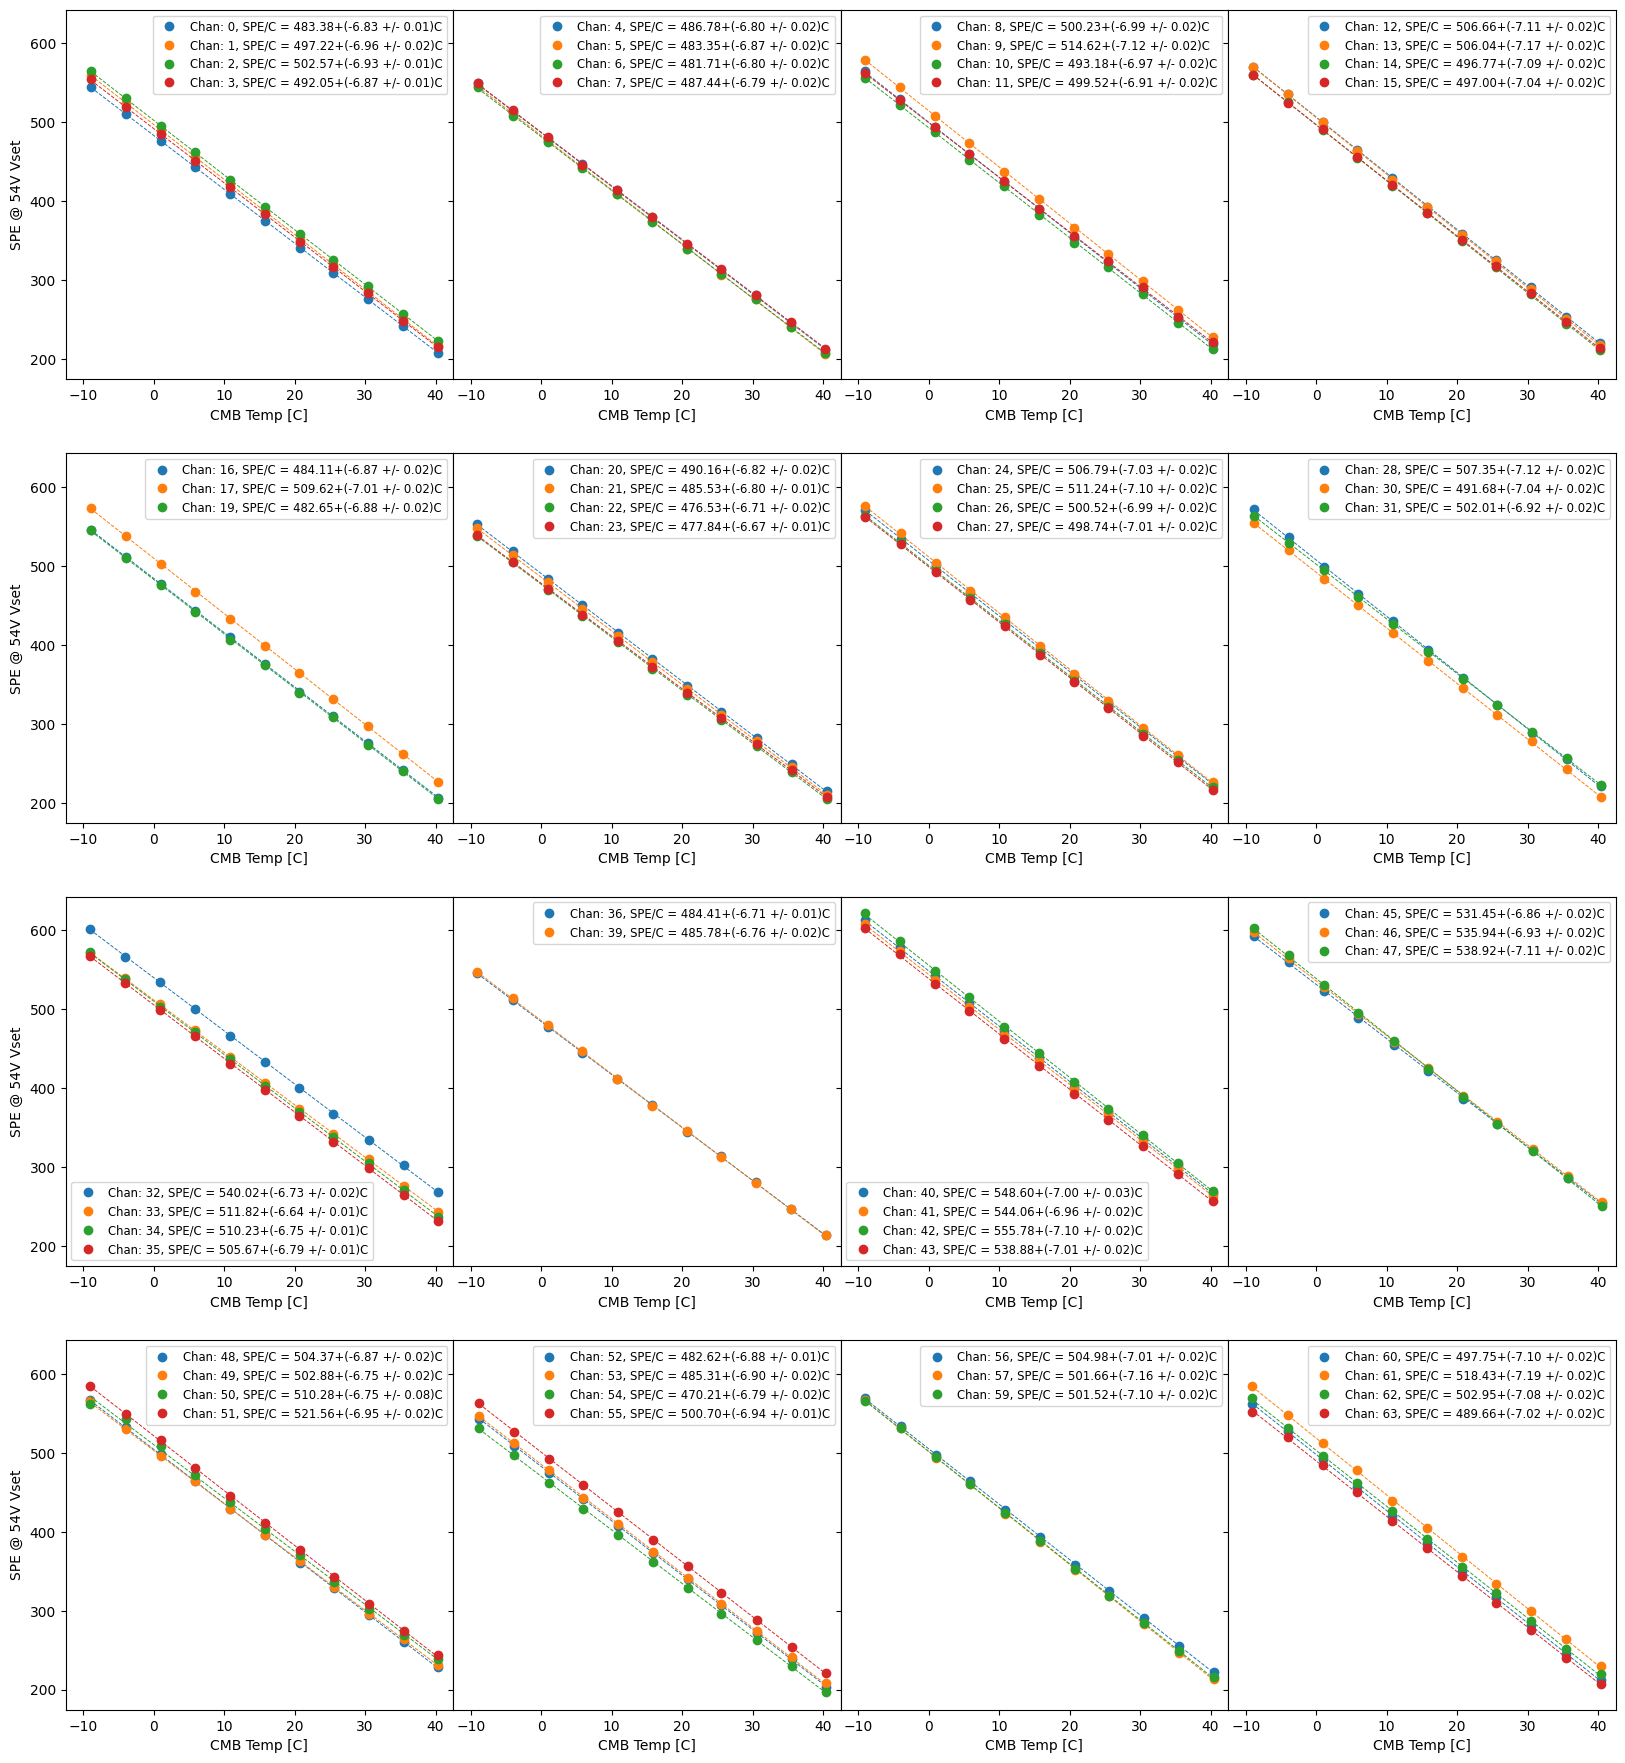

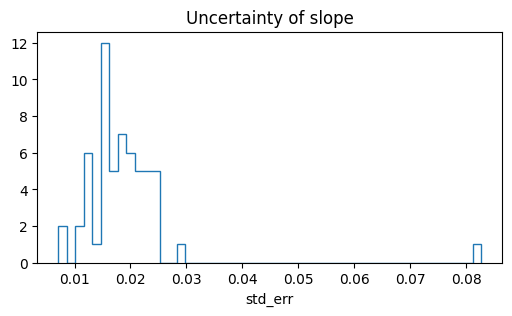

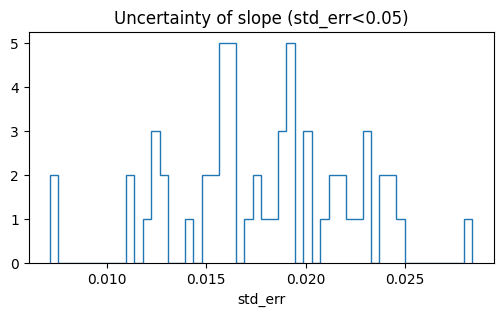

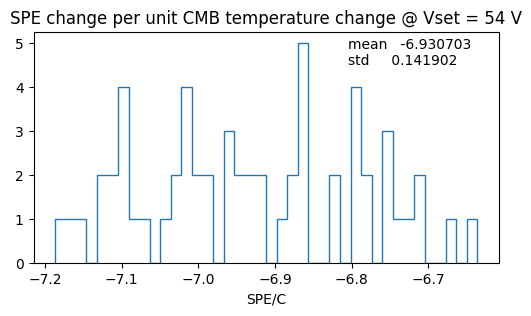

In [6]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_54V_fix'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vset = 54 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ 54V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(150, 700)
plt.show()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_54V_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE @ 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels:
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['spe_54V_fix'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        df_54V_Temp.loc[len(df_54V_Temp)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()
plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp.query('std_err<0.05')['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope (std_err<0.05)')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp.query('std_err<0.3')['slope'], histtype='step', bins=40)
plt.title('SPE change per unit CMB temperature change @ Vset = 54 V')
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, df_54V_Temp['slope'].describe().loc[['mean','std']].to_string())
plt.show()

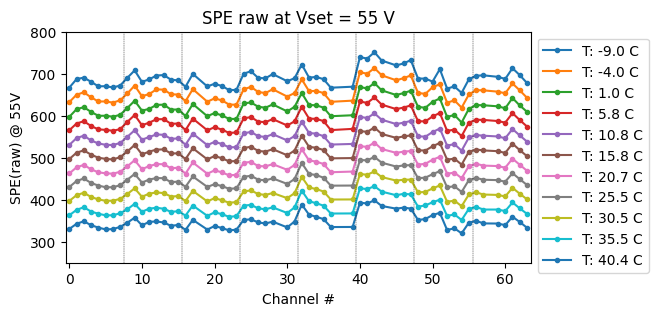

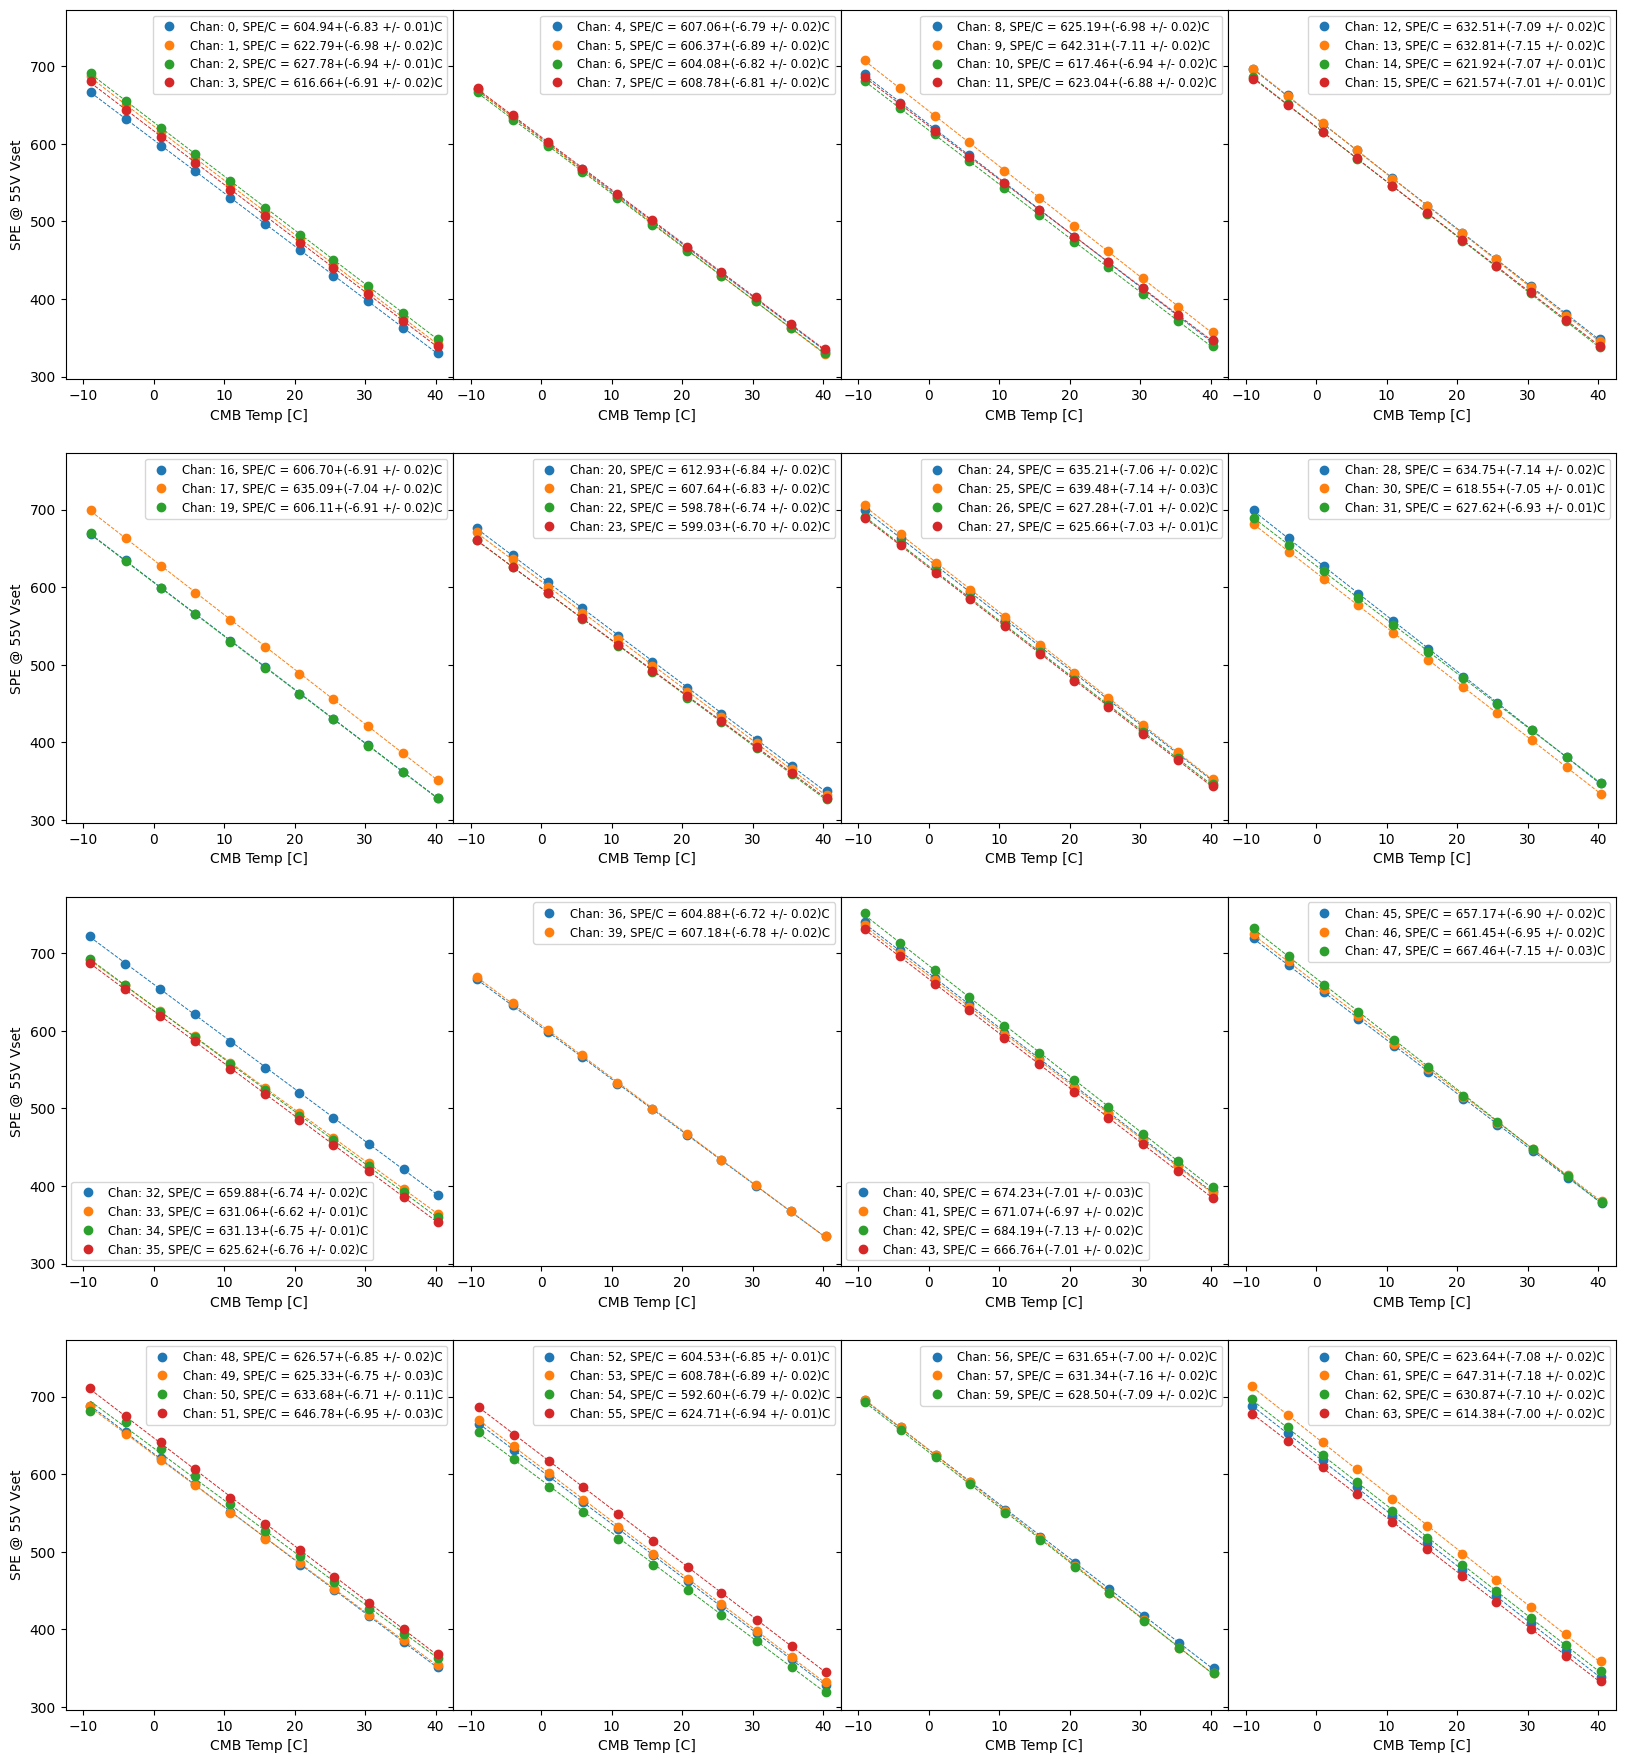

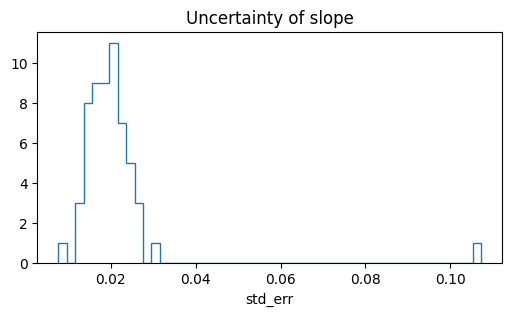

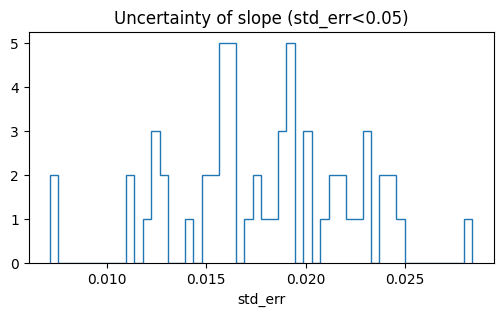

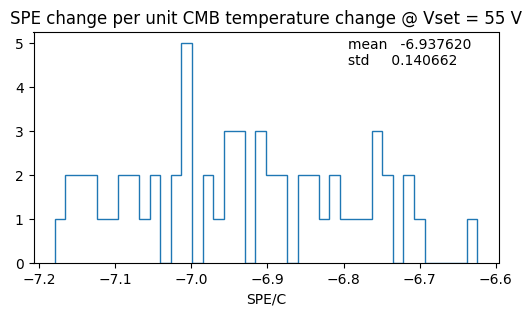

In [7]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_55V_fix'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vset = 55 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ 55V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(250, 800)
plt.show()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_55V_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE @ 55V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels:
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['spe_55V_fix'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        df_55V_Temp.loc[len(df_55V_Temp)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_55V_Temp['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()
plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp.query('std_err<0.05')['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope (std_err<0.05)')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_55V_Temp.query('std_err<0.3')['slope'], histtype='step', bins=40)
plt.title('SPE change per unit CMB temperature change @ Vset = 55 V')
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, df_55V_Temp['slope'].describe().loc[['mean','std']].to_string())
plt.show()

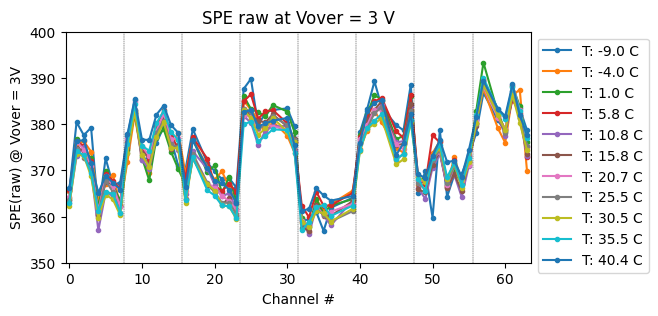

In [8]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_3V_over'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ Vover = 3V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(350, 400)
plt.show()

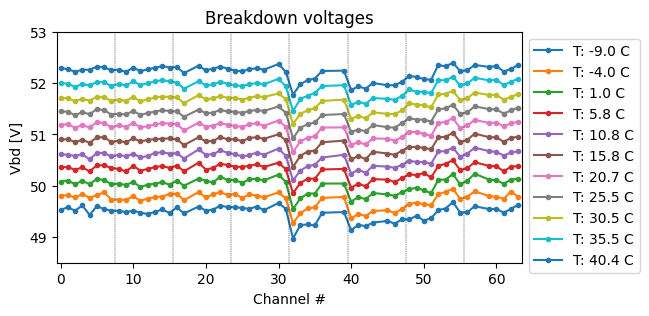

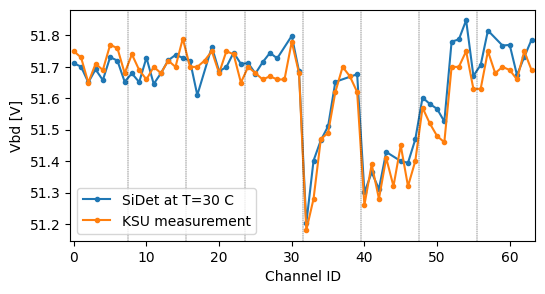

In [9]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['Vbd'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("Breakdown voltages")
plt.xlabel("Channel #")
plt.ylabel("Vbd [V]")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(48.5, 53)
plt.show()

#Measurements from KSU
Vbd_txt = '''
    B4852		A31671	A31687	A31688	A31694	51.75	51.73	51.65	51.71
    B4922		A31723	A31714	A31719	A31716	51.69	51.77	51.76	51.68
    B4918		A31682	A31686	A31684	A31685	51.74	51.69	51.66	51.7
    B4920		A31724	A31725	A31721	A31715	51.68	51.72	51.7	51.79
    B3188		A14512	A14522	A14514	A14252	51.34	51.4	51.4	51.3
    B5087		A31679	A31666	A31676	A31678	51.72	51.69	51.66	51.65
    B4854		A31693	A31680	A31683	A31689	51.72	51.66	51.7	51.7
    B4919		A31681	A31722	A31712	A31720	51.75	51.69	51.71	51.66
    B1267		A14255	A14243	A14250	A14251	51.26	51.39	51.28	51.41
    B1287		A14526	A14523	A14516	A14524	51.32	51.45	51.32	51.4
    B1992		A15426	A15438	A15439	A15427	51.57	51.52	51.48	51.46
    B4924		A31677	A31675	A31673	A31668	51.7	51.7	51.75	51.63
    B5005		A31632	A31665	A31670	A31664	51.63	51.75	51.68	51.7
    B5088		A31672	A31674	A31667	A31669	51.69	51.66	51.75	51.69
    B4921		A31713	A31718	A31717	A31726	51.7	51.7	51.72	51.75
    B4853		A31690	A31691	A31695	A31692	51.68	51.75	51.74	51.65
    B4915		A31734	A31737	A31739	A31741	51.7	51.68	51.66	51.67
    B4983		A31738	A31740	A31731	A31735	51.66	51.66	51.78	51.68
    B1270		A14240	A14244	A15431	A15429	51.18	51.28	51.47	51.49
    B4923		A31728	A31729	A31743	A31736	51.62	51.7	51.67	51.62
    '''
Vbd_txt = Vbd_txt.strip().split('\n')
Vbd_dict = {}
for line in Vbd_txt:
    tID = line.split('\t')[0].lstrip()
    tVbd = [float(x) for x in line.split('\t')[6:]]
    Vbd_dict.update({tID:tVbd})
ID_list = ["B4852", "B4922", "B4918", "B4920",
           # "B1267", "B1287", "B1992", "B4924", "B5005", "B5088",
           "B4921", "B4853", "B4915", "B4983", "B1270", "B4923",
           "B1267", "B1287", "B1992", "B4924", "B5005", "B5088"]
ch = [i for i in range(64)]
Vbd = []
for ID in ID_list:
    Vbd += Vbd_dict[ID]

#Compare KSU and SiDet
temp_KSU=30
df_ = df_SPE_clean.query('temp_setup == %f'%temp_KSU)
plt.figure(figsize = (6,3))
plt.plot(df_['chan'], df_['Vbd'], '.-', label=('SiDet at T=%d C'%np.mean(df_['tempCMB_mean'])))
plt.plot(Vbd, '.-', label='KSU measurement');
plt.xlabel('Channel ID')
plt.ylabel('Vbd [V]')
plt.legend()
for iAFE in range(0, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.show()


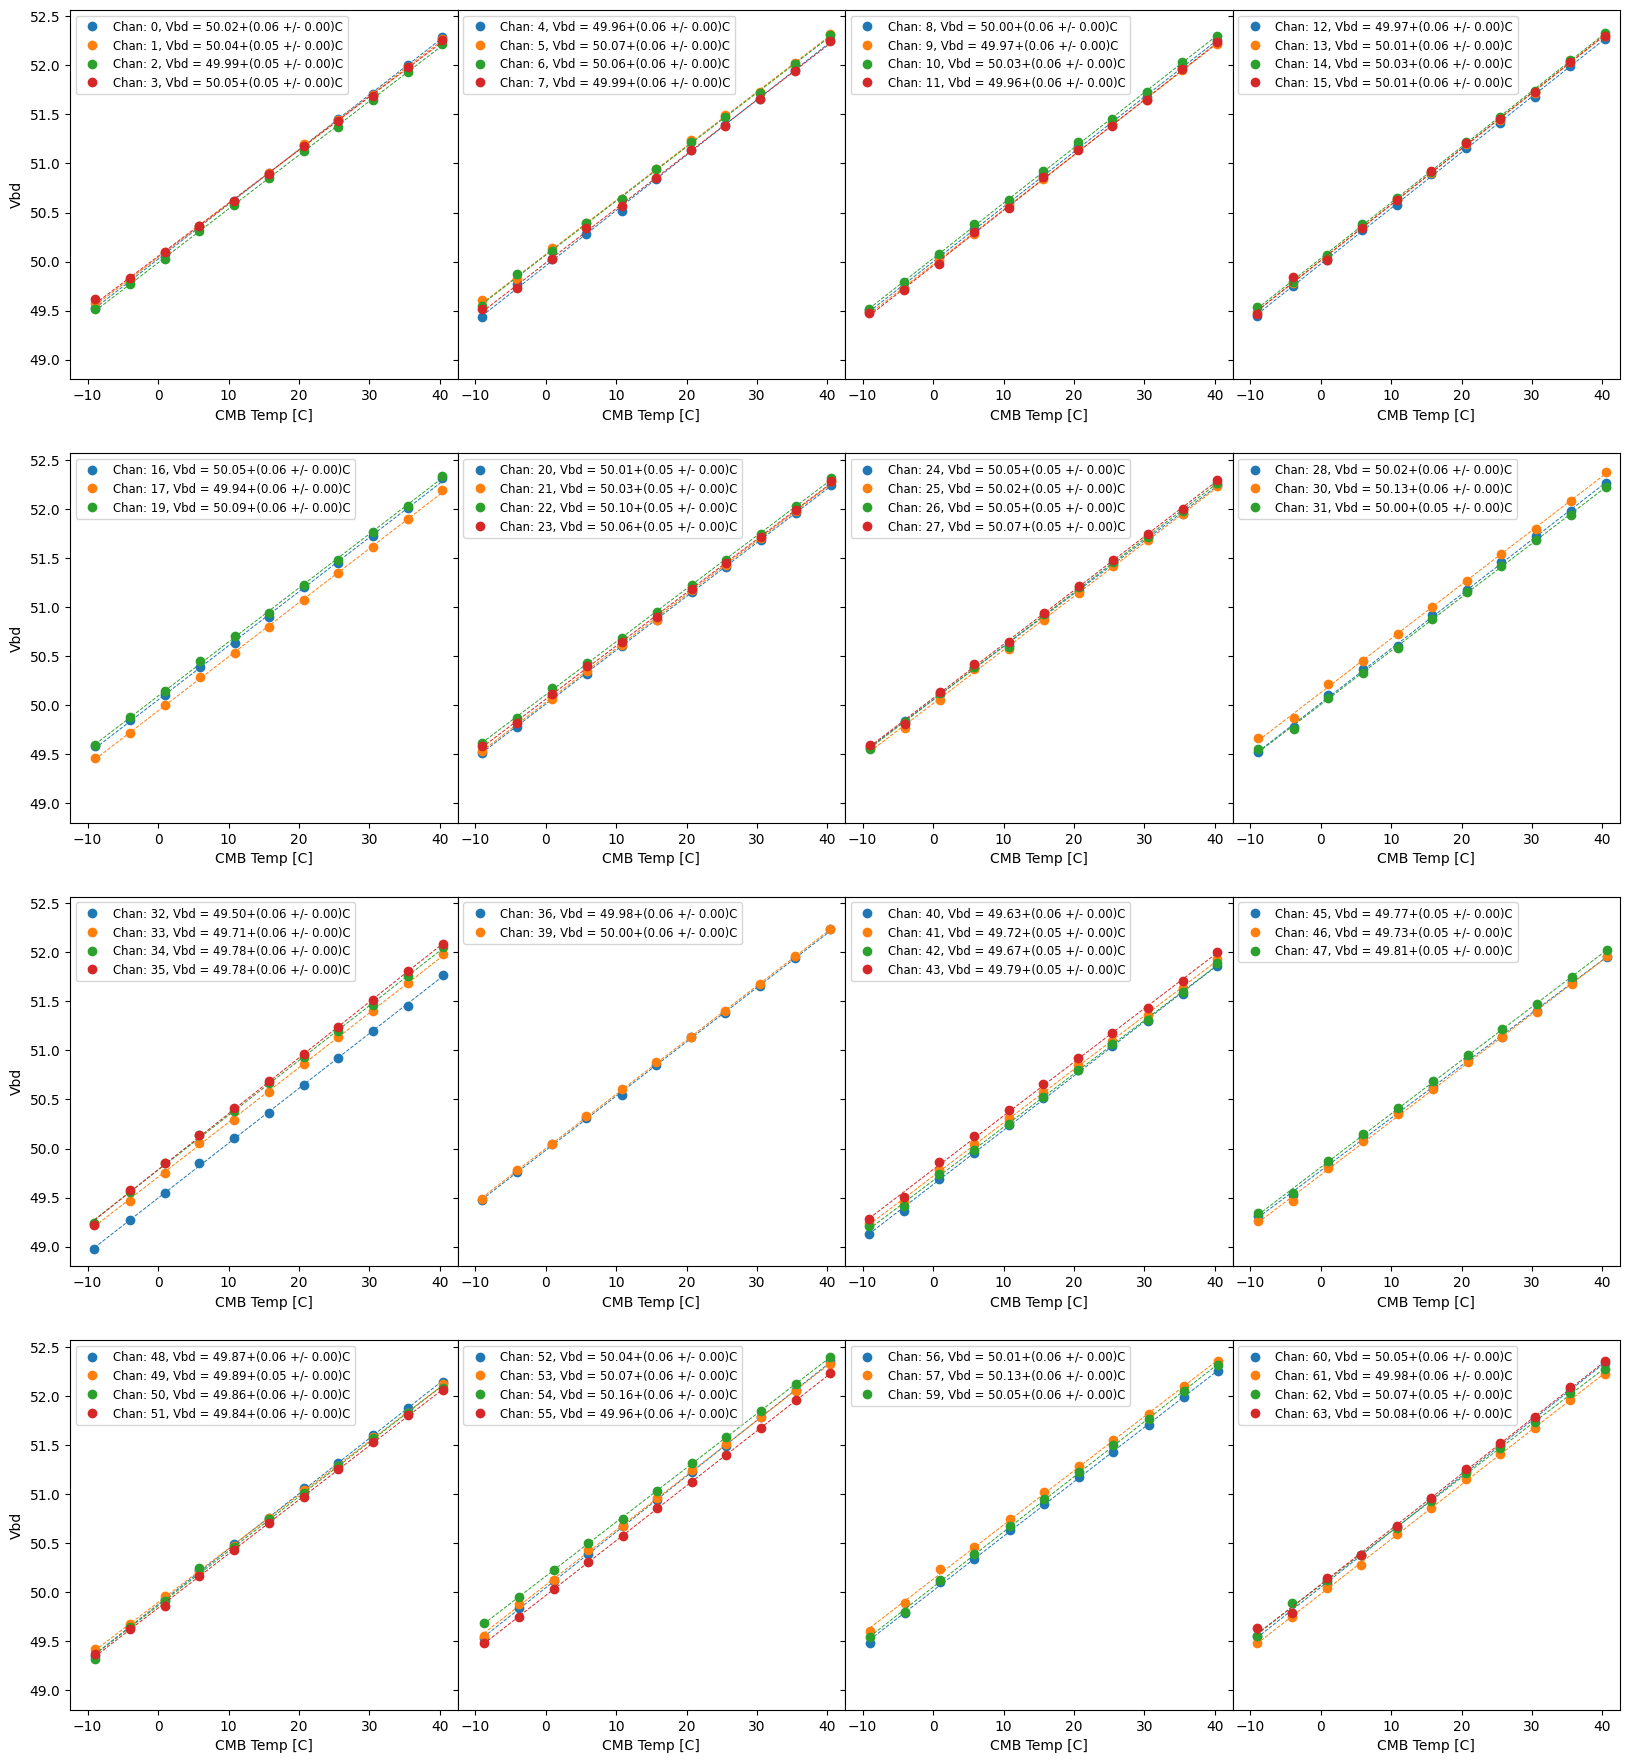

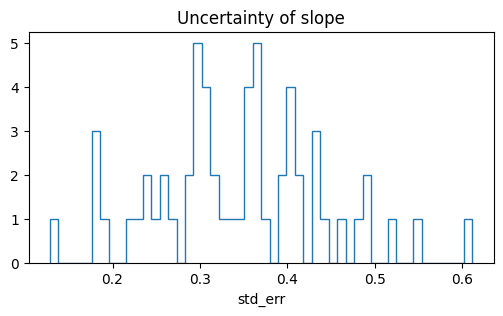

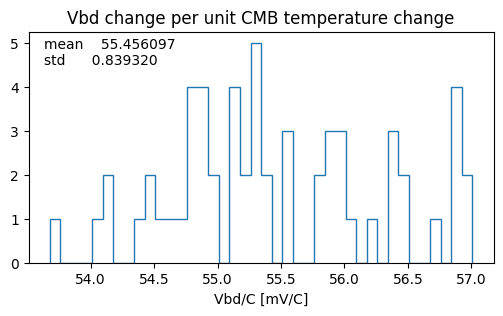

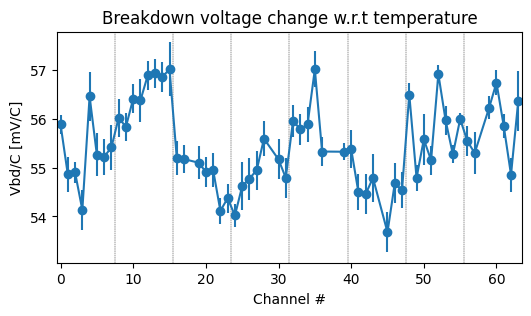

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_Vbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels:
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['Vbd'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        df_Vbd.loc[len(df_Vbd)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_Vbd['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_Vbd.query('std_err<5')['slope'], histtype='step', bins=40)
plt.title('Vbd change per unit CMB temperature change')
plt.xlabel('Vbd/C [mV/C]');
plt.figtext(0.15,0.77, df_Vbd['slope'].describe().loc[['mean','std']].to_string())
plt.show()

plt.figure(figsize = (6,3))
plt.errorbar(df_Vbd['chan'], df_Vbd['slope'], yerr = df_Vbd['std_err'], marker='o')
plt.title("Breakdown voltage change w.r.t temperature")
plt.xlabel("Channel #")
plt.ylabel("Vbd/C [mV/C]")
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.show()

In [11]:
#save dfs
pklname = os.path.join(analysis_dir,"tempScanSiDetRun1SPE.pkl")
with open(pklname, 'wb') as f:
    pickle.dump(df_SPE_clean, f)
    pickle.dump(df_54V_Temp, f)
    pickle.dump(df_55V_Temp, f)
    pickle.dump(df_Vbd, f)    

NOTICE: Yuri's analysis used temperatures from the sensor, while the analysis here used CMB temperatures!!!